# Merging subdomain dfsu files

During simulation MIKE will commonly split simulation files into
subdomains and output results with a p\_# suffix. This script will merge
dfsu files of this type into a single file.

Note: Below implementation considers a 2D dfsu file. For 3D dfsu file,
the script needs to be modified accordingly.

## Import libraries

In [1]:
import mikeio 
import numpy as np
from mikeio.spatial import GeometryFM2D

In [2]:
# (optional) check first file, items etc. 
mikeio.open("../../data/SimA_HD_p0.dfsu")

<mikeio.Dfsu2DH>
number of elements: 194
number of nodes: 120
projection: PROJCS["UTM-32",GEOGCS["Unused",DATUM["UTM Projections",SPHEROID["WGS 1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000],PARAMETER["False_Northing",0],PARAMETER["Central_Meridian",9],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]
items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  Current speed <Current Speed> (meter per sec)
  2:  Current direction <Current Direction> (radian)
time: 2014-01-01 00:00:00 - 2014-01-01 10:00:00 (3 records)

## Choose items to process

In [3]:
# choose items to process (when in doubt look at one of the files you want to process with mikeio.open)
items = ["Surface elevation", "Current speed", "Current direction"]

## Read files

Option A: automatically find all with \_p# suffix

In [4]:
import glob
import os

basename = "../../data/SimA_HD"  # basename of the dfsu files


def find_dfsu_files(basename):
    pattern = f"{basename}_p*.dfsu"
    files = sorted(glob.glob(pattern))
    if not files:
        raise ValueError(f"No files found matching the pattern: {pattern}")
    return files


dfs_files = find_dfsu_files(basename)
print(f"Found {len(dfs_files)} files:")
for file in dfs_files:
    print(f"  - {os.path.basename(file)}")

dfs_list = [mikeio.read(file, items=items) for file in dfs_files]

Found 4 files:
  - SimA_HD_p0.dfsu
  - SimA_HD_p1.dfsu
  - SimA_HD_p2.dfsu
  - SimA_HD_p3.dfsu

Option B: manually select files

In [5]:
# List of input dfsu files
dfs_files = [
    "../../data/SimA_HD_p0.dfsu",
    "../../data/SimA_HD_p1.dfsu",
    "../../data/SimA_HD_p2.dfsu",
    "../../data/SimA_HD_p3.dfsu",
]

# read all dfsu files
dfs_list = [mikeio.read(file, items=items) for file in dfs_files]

## Extract data of all subdomains

In [6]:
# Create a dictionary to store data for each item
data_dict = {item: [] for item in items}

# Get time steps (assuming all files have the same time steps)
time_steps = dfs_list[0][items[0]].time

# loop over items and time steps and concatenate data from all subdomains
for item in items:
    for i in range(len(time_steps)):
        # Extract and combine data for the current time step from all subdomains
        combined_data = np.concatenate([dfs[item].values[i, :] for dfs in dfs_list])
        data_dict[item].append(combined_data)
    
    # Convert the list to a numpy array
    data_dict[item] = np.array(data_dict[item])

# Prepare Merged Data
merged_data = np.array([data_dict[item] for item in items])

## Merge geometry of all subdomains

In [7]:
geometries = [dfs.geometry for dfs in dfs_list]

combined_node_coordinates = []
combined_element_table = []
node_offset = 0

# loop through geometries to combine nodes and elements of all subdomains
for geom in geometries:
    current_node_coordinates = geom.node_coordinates
    current_element_table = geom.element_table
    
    combined_node_coordinates.extend(current_node_coordinates)
    adjusted_element_table = [element + node_offset for element in current_element_table]
    combined_element_table.extend(adjusted_element_table)
    
    node_offset += len(current_node_coordinates)

combined_node_coordinates = np.array(combined_node_coordinates)
combined_element_table = np.array(combined_element_table, dtype=object)
projection = geometries[0]._projstr

# create combined geometry
combined_geometry = GeometryFM2D(
    node_coordinates=combined_node_coordinates,
    element_table=combined_element_table,
    projection=projection
)

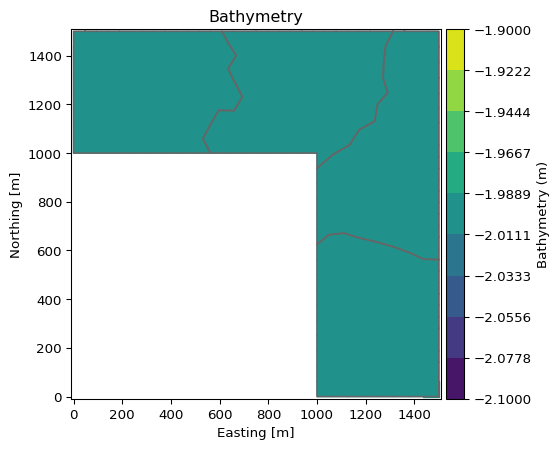

In [8]:
combined_geometry.plot()

## Merge everything into dataset

In [9]:
ds_out = mikeio.Dataset.from_numpy(
    data=merged_data,  # n_items, timesteps, n_elements
    items=items,
    time=time_steps,
    geometry=combined_geometry,
)

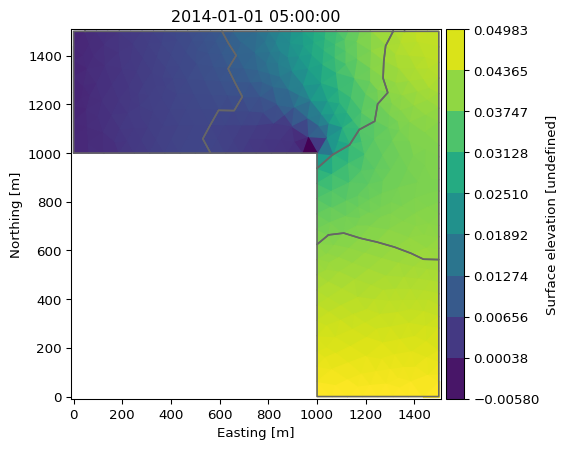

In [10]:
ds_out[items[0]].sel(time=1).plot() # plot the first time step of the first item

## Write output to single file

In [11]:
output_file = "area_merged.dfsu"
ds_out.to_dfs(output_file)